In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.4 MB/s eta 0:00:00


In [2]:
# Common libraries for data cleaning and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import load # use to load an npz file
from scipy.signal import periodogram # use to graph a periodogram to get seasonality analysis
from sklearn.preprocessing import MinMaxScaler # use to normalize the data features

# keras library to create NN models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# libraries for the metrics we will use (RMSE and Spearman)
from keras.metrics import RootMeanSquaredError
import scipy.stats as stats

In [3]:
# Set plot settings
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['grid.alpha'] = 0.5

In [4]:
traffic = pd.read_csv('/content/drive/MyDrive/traffic.csv')

In [5]:
print(len(traffic))
traffic.head()

3035520


,timestep,location,flow,occupy,speed
0,1,0,133.0,0.0603,65.8
1,1,1,210.0,0.0589,69.6
2,1,2,124.0,0.0358,65.8
3,1,3,145.0,0.0416,69.6
4,1,4,206.0,0.0493,69.4


In [6]:
traffic.info()
traffic.count()
traffic.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3035520 entries, 0 to 3035519
Data columns (total 5 columns):
 #   Column    Dtype  
---  ------    -----  
 0   timestep  int64  
 1   location  int64  
 2   flow      float64
 3   occupy    float64
 4   speed     float64
dtypes: float64(3), int64(2)
memory usage: 115.8 MB


,0
timestep,0
location,0
flow,0
occupy,0
speed,0


In [7]:
traffic.describe()

,timestep,location,flow,occupy,speed
count,3.035520e+06,3.035520e+06,3.035520e+06,3.035520e+06,3.035520e+06
mean,8.928500e+03,8.450000e+01,2.306807e+02,6.507109e-02,6.376300e+01
std,5.154584e+03,4.907393e+01,1.462170e+02,4.590215e-02,6.652010e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,4.464750e+03,4.200000e+01,1.100000e+02,3.570000e-02,6.260000e+01
50%,8.928500e+03,8.450000e+01,2.150000e+02,6.010000e-02,6.490000e+01
75%,1.339225e+04,1.270000e+02,3.340000e+02,8.390000e-02,6.740000e+01
max,1.785600e+04,1.690000e+02,1.147000e+03,8.955000e-01,8.230000e+01


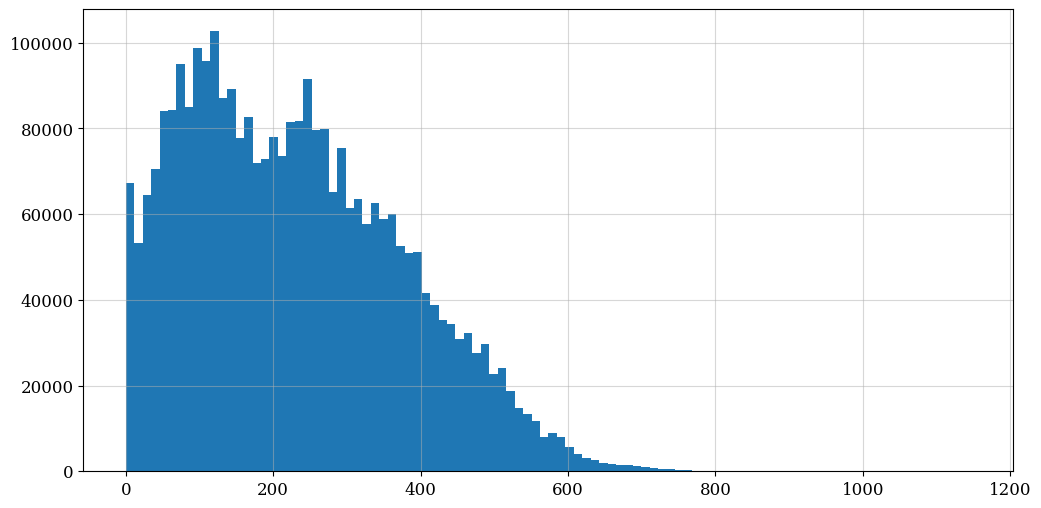

In [8]:
traffic['flow'].hist(bins=100);

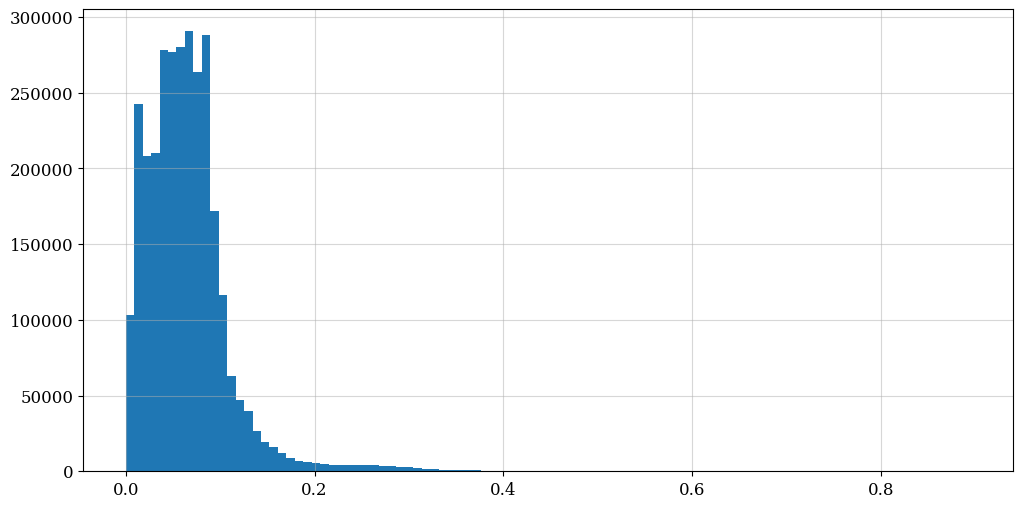

In [9]:
traffic['occupy'].hist(bins=100);

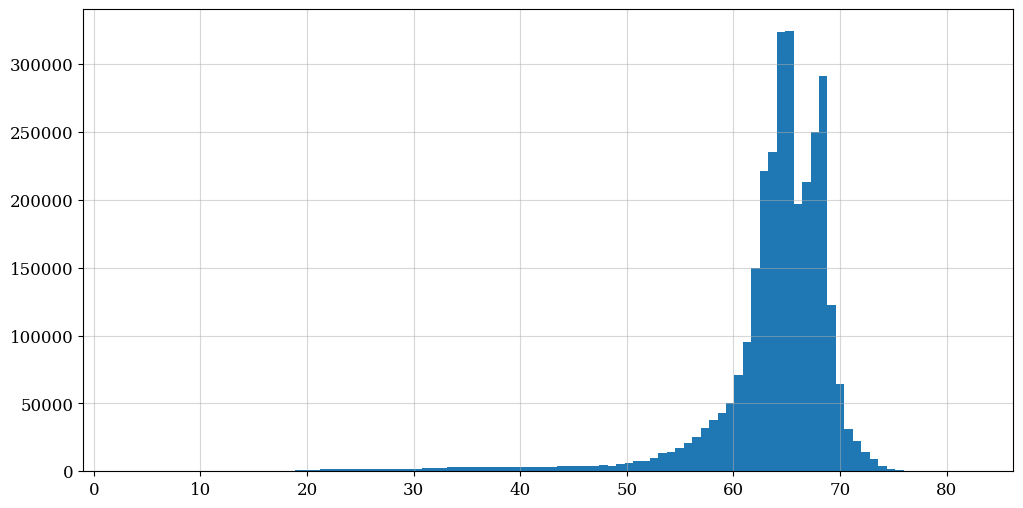

In [10]:
traffic['speed'].hist(bins=100);

In [11]:
location_0 = traffic[traffic["location"]==50].reset_index()
location_0.head()

,index,timestep,location,flow,occupy,speed
0,50,1,50,76.0,0.0262,69.5
1,220,2,50,81.0,0.0255,68.8
2,390,3,50,80.0,0.0243,69.0
3,560,4,50,76.0,0.0255,68.4
4,730,5,50,70.0,0.0224,68.1


<Axes: >

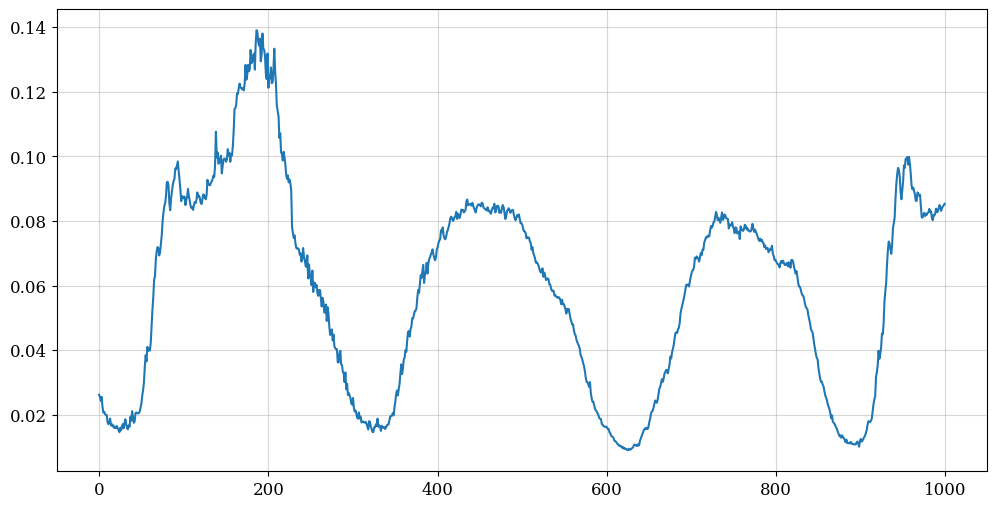

In [12]:
location_0["occupy"][:1000].plot()

<Axes: >

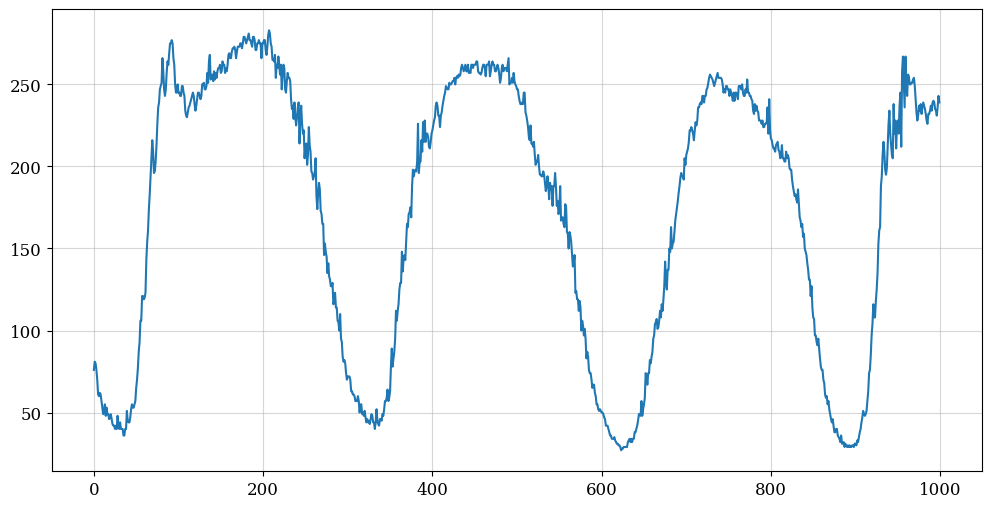

In [13]:
location_0["flow"][:1000].plot()

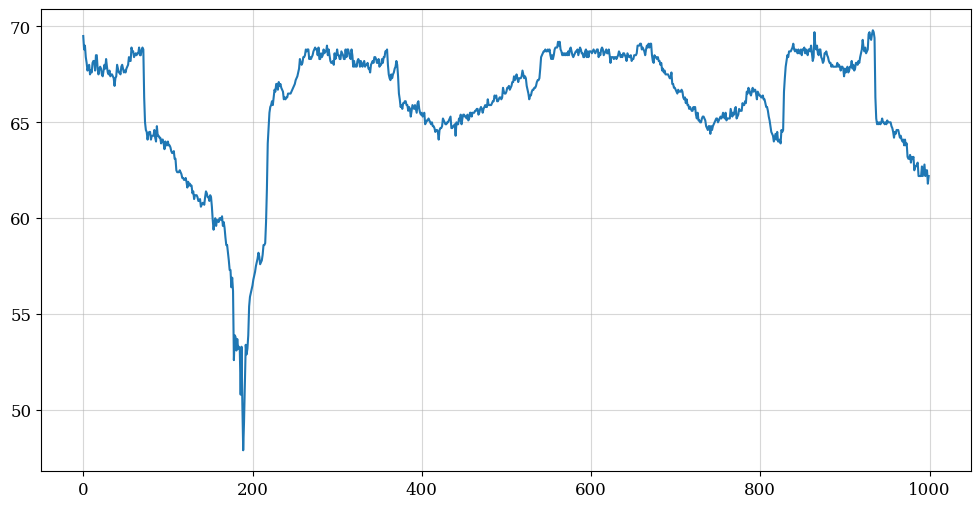

In [14]:
location_0["speed"][:1000].plot();

In [15]:
COR_STEP = 1
pres = traffic[['flow', 'occupy', 'speed']][0:-(COR_STEP)].reset_index(drop=True)
future = traffic[['flow', 'occupy', 'speed']][COR_STEP:] \
    .reset_index(drop=True) \
    .add_suffix('_future')
val = pres.join(future)
val.corr()

,flow,occupy,speed,flow_future,occupy_future,speed_future
flow,1.000000,0.674039,-0.296332,0.535235,0.450192,-0.235030
occupy,0.674039,1.000000,-0.752040,0.445282,0.477379,-0.303858
speed,-0.296332,-0.752040,1.000000,-0.228266,-0.275180,0.233537
flow_future,0.535235,0.445282,-0.228266,1.000000,0.674040,-0.296331
occupy_future,0.450192,0.477379,-0.275180,0.674040,1.000000,-0.752040
speed_future,-0.235030,-0.303858,0.233537,-0.296331,-0.752040,1.000000


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

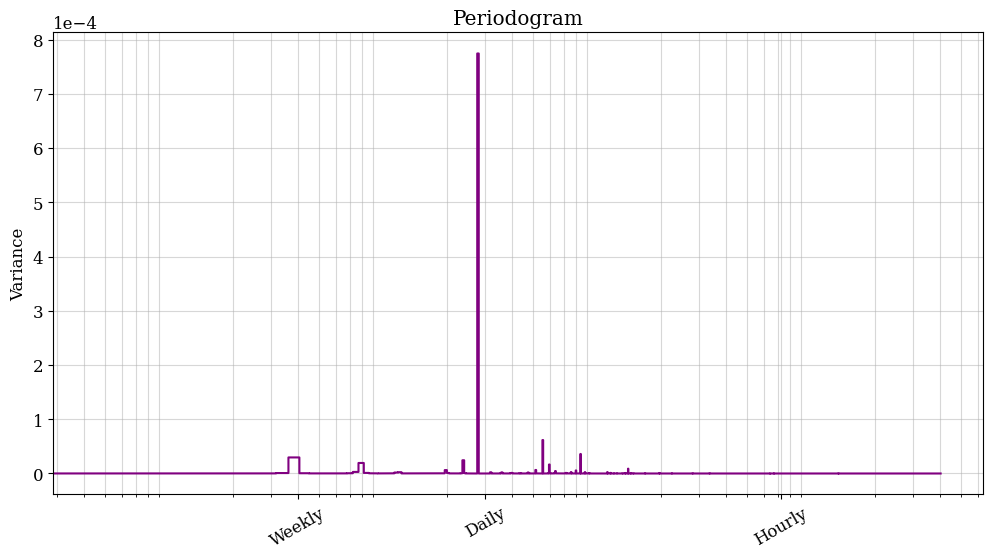

In [16]:
def plot_periodogram(ts, detrend='linear', ax=None):
    """
    Plots the periodogram of a time series.

    Args:
        ts (pd.Series): A time series.
        detrend (str): Detrending method for the time series.
        ax (matplotlib.axes.Axes): The axes on which to plot.

    Returns:
        ax (matplotlib.axes.Axes): The axes on which the periodogram is plotted.
    """
    fs = pd.Timedelta(weeks=4) / pd.Timedelta(minutes=5)
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()

    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([4, 30, 30*24])
    ax.set_xticklabels(
        [
            "Weekly",
            "Daily",
            "Hourly"
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

plot_periodogram(location_0["occupy"])

In [17]:
location_0["hour"] = ((location_0["timestep"] - 1) // 4)
grouped = location_0.groupby("hour").mean().reset_index()
grouped.head()

,hour,index,timestep,location,flow,occupy,speed
0,0,305.0,2.5,50.0,78.25,0.025375,68.925
1,1,985.0,6.5,50.0,63.25,0.021050,67.925
2,2,1665.0,10.5,50.0,55.00,0.018675,67.725
3,3,2345.0,14.5,50.0,51.75,0.017550,68.150
4,4,3025.0,18.5,50.0,47.75,0.016300,67.900


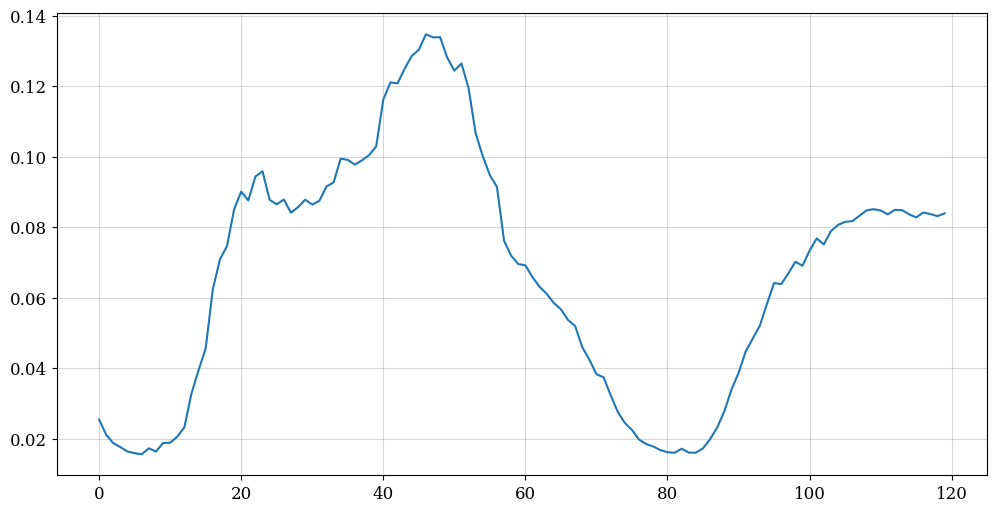

In [18]:
grouped["occupy"][:24*5].plot();

In [19]:
COR_STEP = 4
pres = grouped[['flow', 'occupy', 'speed']][0:-(COR_STEP)].reset_index(drop=True)
future = grouped[['flow', 'occupy', 'speed']][COR_STEP:] \
    .reset_index(drop=True) \
    .add_suffix('_future')
val = pres.join(future)
val.corr()

,flow,occupy,speed,flow_future,occupy_future,speed_future
flow,1.000000,0.964131,-0.706682,0.892727,0.841676,-0.631341
occupy,0.964131,1.000000,-0.828916,0.890533,0.880369,-0.721951
speed,-0.706682,-0.828916,1.000000,-0.707299,-0.773359,0.808781
flow_future,0.892727,0.890533,-0.707299,1.000000,0.964107,-0.706687
occupy_future,0.841676,0.880369,-0.773359,0.964107,1.000000,-0.828950
speed_future,-0.631341,-0.721951,0.808781,-0.706687,-0.828950,1.000000


In [20]:
# # creating 3-dimensional array for [timestep, timeframe, features]
def create_dataset(location, WINDOW_SIZE):

    # mask a certain location
    location_current = traffic[traffic["location"]==location].reset_index()

    # group to halfhour and average 12 (5-minute) timesteps
    location_current["hour"] = ((location_current["timestep"] - 1) // 4)
    grouped = location_current.groupby("hour").mean().reset_index()

    # add hour features as mod 24 cycle (0...23)
    grouped['day'] = (grouped['hour'] // 96) % 7
    grouped['hour'] %= 96

    one_hot_hour = pd.get_dummies(grouped['hour'])
    one_hot_hour = one_hot_hour.add_prefix('hour_')

    # merge all the features together to get a total of 27 features
    hour_grouped = pd.concat([grouped[["occupy", "flow", "speed"]], one_hot_hour], axis=1)
    hour_grouped = np.array(hour_grouped)

    X, Y = [], []

    # add lag features (in reverse time order)
    for i in range(len(hour_grouped) - WINDOW_SIZE):
        X.append(hour_grouped[i:(i + WINDOW_SIZE)][::-1]) # reverse the order
        Y.append(hour_grouped[i + WINDOW_SIZE, 0]) # index 0 is occupy

    return X,Y # returns (timestep, timeframe, features) and (target)


In [21]:
# creating 4-th dimension for the locations
X, Y = [], []

for location in range(170):
    a,b = create_dataset(location, WINDOW_SIZE=96)
    X.append(a)
    Y.append(b)

X = np.moveaxis(X,0,-1)
Y = np.moveaxis(Y,0,-1)

print(X.shape)
print(Y.shape)

(4368, 96, 99, 170)
(4368, 170)


In [22]:
TRAIN_SIZE = 0.8
TEST_SIZE  = 0.2

train_size = int(len(X) * TRAIN_SIZE)
test_size  = int(len(X) * TEST_SIZE)

train_X, train_Y = X[:train_size], Y[:train_size]
test_X, test_Y = X[train_size:], Y[train_size:]

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(3494, 96, 99, 170)
(3494, 170)
(874, 96, 99, 170)
(874, 170)


In [23]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
train_X = scaler_X.fit_transform(train_X.reshape(train_X.shape[0] * train_X.shape[1], -1)) \
                   .reshape(train_X.shape[0], train_X.shape[1], -1)
test_X = scaler_X.transform(test_X.reshape(test_X.shape[0] * test_X.shape[1], -1)) \
                   .reshape(test_X.shape[0], test_X.shape[1], -1)
train_Y = scaler_Y.fit_transform(train_Y)
test_Y = scaler_Y.transform(test_Y)

In [24]:
print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(test_Y.shape)

(3494, 96, 16830)
(874, 96, 16830)
(3494, 170)
(874, 170)




> Model Training goes from here
> Earlier we used the preprocessing and data setup



In [25]:
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])),
    LSTM(256, return_sequences=False),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(170, activation='linear'),
])

model.compile(loss='mse', optimizer='adam', metrics=[RootMeanSquaredError()])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 96, 256)        │    17,497,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 170)            │        43,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,131,882 (69.17 MB)

 Trainable params: 18,131,882 (69.17 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
# Train the model
history = model.fit(train_X, train_Y, epochs=10, batch_size=32, validation_split=0.1, verbose=2)

Epoch 1/10


In [34]:
def plot_training(training_history, text, width):
    history = training_history.history[text]

    # creates a moving average plot to reduce variations
    moving_average = [float("NaN") for i in range(width)]
    for i in range(width, len(history)+1):
        moving_average.append(np.mean(np.array(history[i-width:i+1])))

    plt.plot(history)
    plt.plot(moving_average)
    plt.title(text)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['value','moving average'], loc='upper left')
    plt.show()

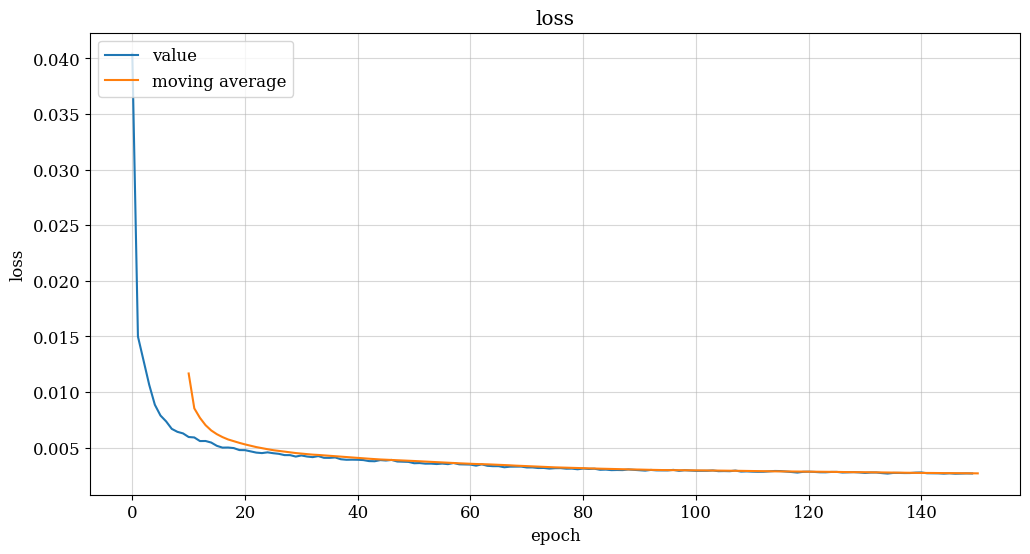

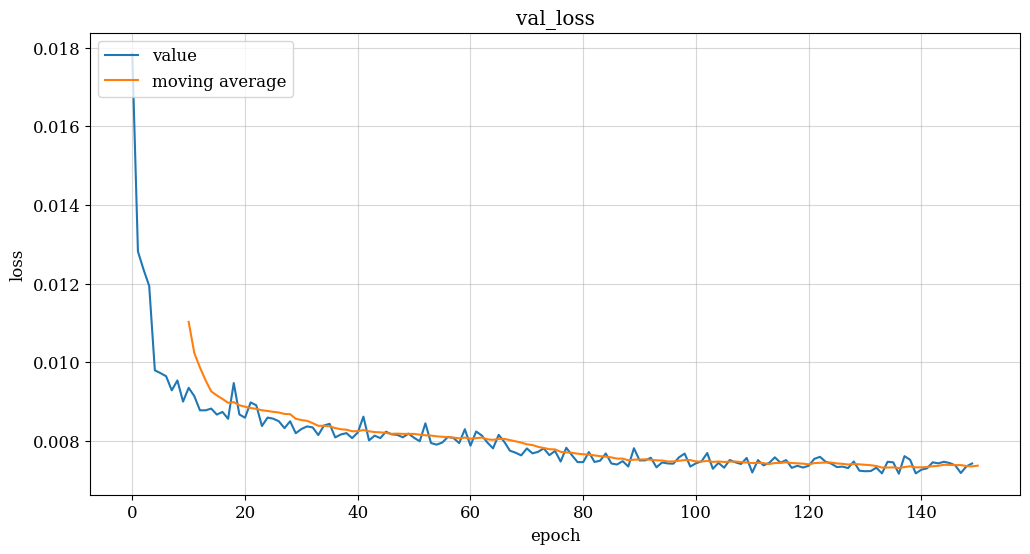

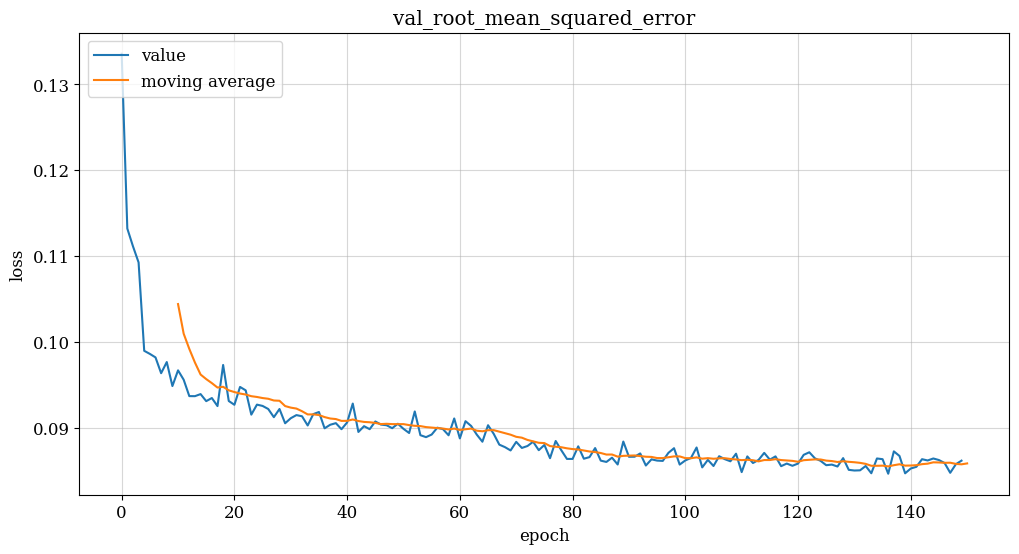

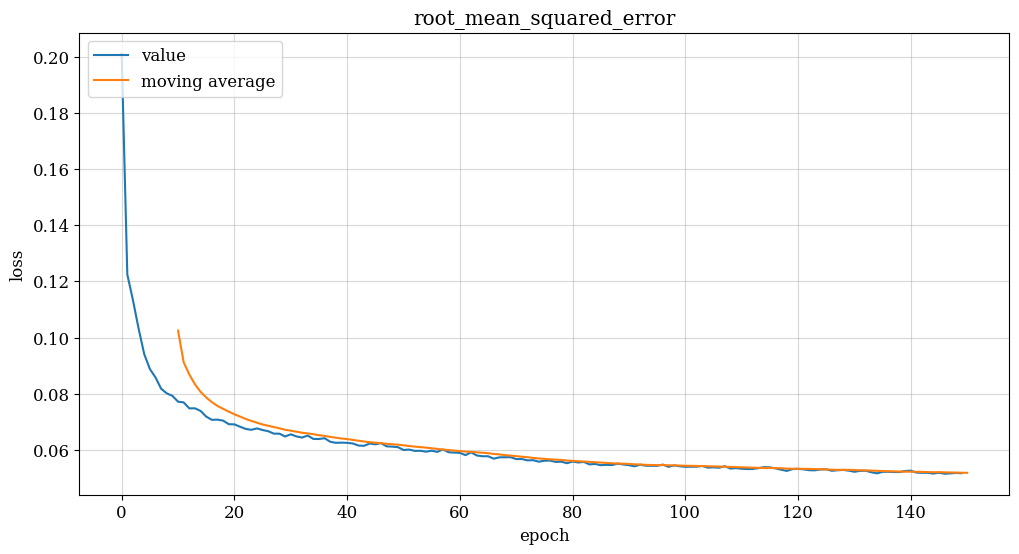

In [35]:
# Plots the loss (MSE and RMSE) of both test and validation data
WIDTH = 10
plot_training(history,'loss',WIDTH)
plot_training(history,'val_loss',WIDTH)
plot_training(history,'val_root_mean_squared_error',WIDTH)
plot_training(history,'root_mean_squared_error',WIDTH)

In [36]:
def predict_and_calc_score(X, Y):
    # prediction of Y using the model
    pred = model.predict(X)
    # moving average of Y
    window_size = 12
    moving_average = np.apply_along_axis(
        lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='same'), axis=0, arr=Y)
    moving_average = np.concatenate((np.zeros((1, Y.shape[1])), moving_average), axis=0)[:Y.shape[0]]

    # scale it back to the original scale
    pred_scaled = scaler_Y.inverse_transform(pred)
    moving_average_scaled = scaler_Y.inverse_transform(moving_average)
    Y_scaled = scaler_Y.inverse_transform(Y)

    # calculate the RMSE
    baseline_RMSE = np.sqrt(np.mean((Y_scaled - moving_average_scaled) ** 2))
    model_RMSE = np.sqrt(np.mean((Y_scaled - pred_scaled) ** 2))

    return Y_scaled, pred_scaled, moving_average_scaled, model_RMSE, baseline_RMSE

def plot_prediction(actual, prediction, moving_average):
    # Plot the actual values
    plt.plot(actual, label="True value", linestyle='-', linewidth=1, marker='s', markersize=1)

    # Plot the moving average
    plt.plot(moving_average, label="Moving Average", linestyle='--', linewidth=1, marker='s', markersize=1)

    # Plot the predicted values
    plt.plot(prediction, label="Prediction", linestyle='--', linewidth=1, marker='o', markersize=1)

    # Set the title and axis labels
    plt.title('Prediction vs. True Value', fontsize=16)
    plt.xlabel('Hour Timesteps')
    plt.ylabel('Output Value')

    # Add a legend to the plot
    plt.legend(loc='upper left', fontsize=12)

    # Display the plot
    plt.show()

In [37]:
train_actual, train_prediction, train_moving_average, train_RMSE, baseline_RMSE = \
    predict_and_calc_score(train_X, train_Y)

print("Train Moving Average RMSE:", baseline_RMSE)
print("Train Prediction RMSE:", train_RMSE)

corr, pval = stats.spearmanr(train_actual, train_moving_average)
mov_spearman_corr = np.mean(corr)
corr, pval = stats.spearmanr(train_actual, train_prediction)
pred_spearman_corr = np.mean(corr)

print("Train Moving Average Spearman Correlation:", mov_spearman_corr)
print("Train Prediction Spearman Correlation:", pred_spearman_corr)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Train Moving Average RMSE: 0.02385027817581988
Train Prediction RMSE: 0.014691603905729128
Train Moving Average Spearman Correlation: 0.7151104382112119
Train Prediction Spearman Correlation: 0.808094038857266


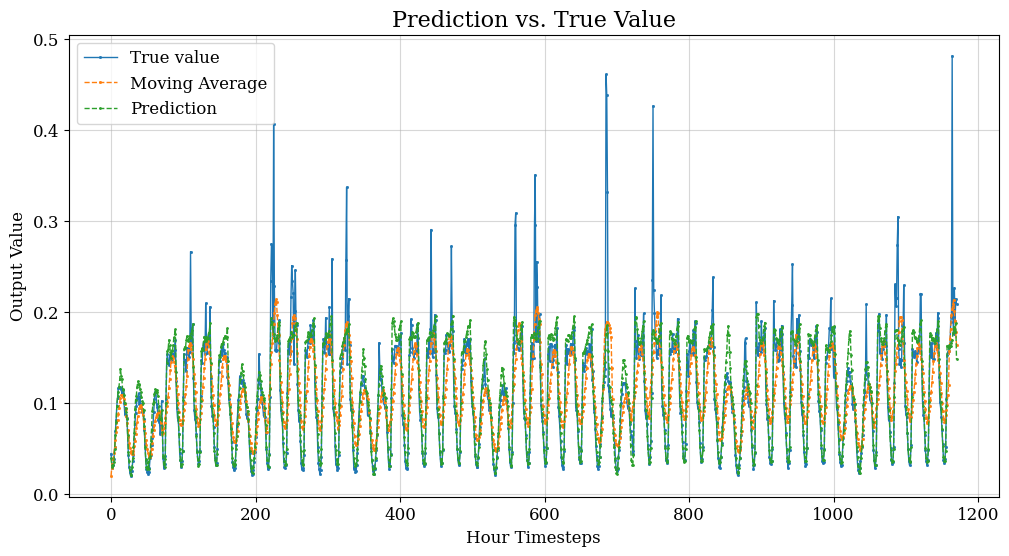

In [38]:
location = 3
plot_prediction(train_actual[:,location], train_prediction[:,location], train_moving_average[:,location])

In [39]:
test_actual, test_prediction, test_moving_average, test_RMSE, baseline_RMSE = \
    predict_and_calc_score(test_X, test_Y)

print("Test Moving Average RMSE:", baseline_RMSE)
print("Test Prediction RMSE:", test_RMSE)

corr, pval = stats.spearmanr(test_actual, test_moving_average)
mov_spearman_corr = np.mean(corr)
corr, pval = stats.spearmanr(test_actual, test_prediction)
pred_spearman_corr = np.mean(corr)

print("Test Moving Average Spearman Correlation:", mov_spearman_corr)
print("Test Prediction Spearman Correlation:", pred_spearman_corr)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test Moving Average RMSE: 0.026519227318993182
Test Prediction RMSE: 0.019885451979929265
Test Moving Average Spearman Correlation: 0.7208932049069978
Test Prediction Spearman Correlation: 0.8194187280802574


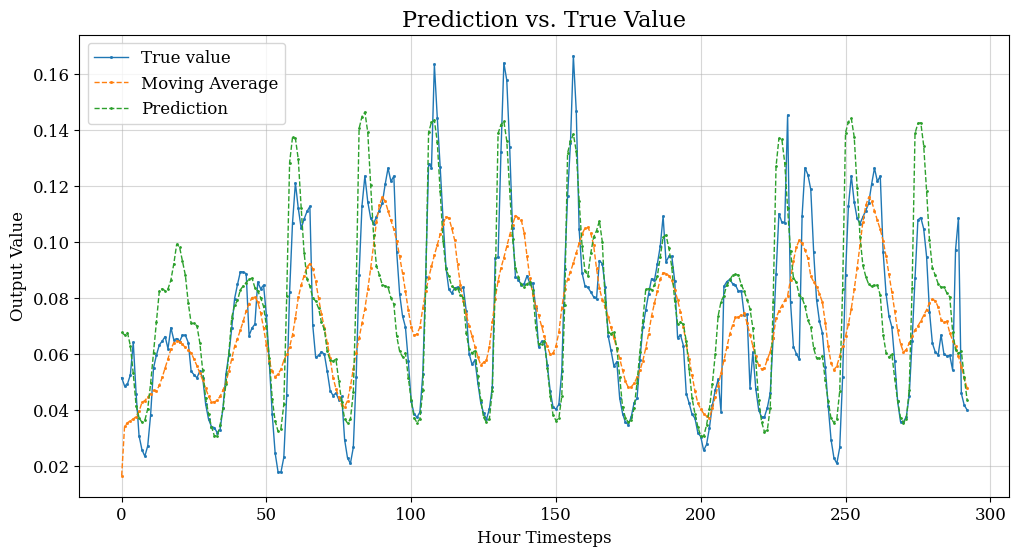

In [40]:
location = 10
plot_prediction(test_actual[:,location], test_prediction[:,location], test_moving_average[:,location])